Summary
=======

Multiclass classification is a classic problem in machine learning and data science. In this project, I have been given a hypothetical data set with the task of predicting if instances fall into either class 0, 1, or 2. After extensive data exploration including the initial and exploratory data analysis to understand the data set, the preprocessing pipeline was built which includes a categorical encoder for the categorical variables and a min-max scaler for the numerical variables. I then proceeded to use the xgboost (XGB) model which is one of the most prolific machine learning algorithms for tabular data, achieving record performance in many data science and ML competitions. I built three different variants of the XGB model including a pretuned model - using default parameters, a tuned model with grid search or exhaustive search method, and a final weighted model to account for data imbalance. I find that the pre-tuned model based achieved the highest performance and was therefore used to generate predictions on the test set. Finally, I discussed some of the major limitations and areas of possible improvement. 

In [1]:
# =========================
# Import necessary modules
# =========================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.utils import class_weight
import xgboost as xgb
from IPython.display import set_matplotlib_formats
from sklearn.model_selection import train_test_split

set_matplotlib_formats("retina")
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# =========================
# Load data to be used
# =========================

y = pd.read_csv("candidate_assignment/train_labels.csv", header=None)
x = pd.read_csv("candidate_assignment/train_features.csv", header=None)
x_test = pd.read_csv("candidate_assignment/test_features.csv", header=None)

<IPython.core.display.Javascript object>

### METHODOLOGY
1. Exploratory Analysis to understand the data: <br>
    a. Intial Exploratory Analysis<br>
    b. Exploratory Data Analysis
2. Preprocessing:<br>
    a. Scaling/Normalization (Numerical Features)<br>
    b. One Hot Encoding (Categorical Features)<br>
3. Model training and hyperparameter tuning<br>
    a. Baseline model <br>
    b. Hyperparameter tuned model <br>
    c. Model + data imbalance weighting <br>
4. Prediction with best model 

### 1. Exploratory Analysis 

#### 1a. Initial Exploratory Analysis

In [3]:
# ==============================
# Label Distribution
# ==============================

label_dist = y.rename(columns={0: "label"}).groupby("label").size()
print(f"Data Distribution: {label_dist}")

Data Distribution: label
0    17
1    82
2    41
dtype: int64


<IPython.core.display.Javascript object>

In [4]:
# ================================
# Feature Distribution
# ================================
cat_features = x[x.columns[:3]]  # categorical features
num_features = x[x.columns[3:]]  # numerical features

<IPython.core.display.Javascript object>

In [5]:
print(
    f" \033[1m Description of Categorical Features:  \033[0m \n {cat_features.describe()}"
)

  Description of Categorical Features:   
            0       1    2
count    140     140  140
unique     2       3    3
top     left  type_3  red
freq      79      64   53


<IPython.core.display.Javascript object>

In [6]:
cat_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       140 non-null    object
 1   1       140 non-null    object
 2   2       140 non-null    object
dtypes: object(3)
memory usage: 3.4+ KB


<IPython.core.display.Javascript object>

In [7]:
for column in cat_features.columns:
    uniques = sorted(cat_features[column].unique())
    print(f"{column, len(uniques), uniques[:5]}")

(0, 2, ['left', 'right'])
(1, 3, ['type_1', 'type_2', 'type_3'])
(2, 3, ['blue', 'green', 'red'])


<IPython.core.display.Javascript object>

In [8]:
print(
    f" \033[1m Description of Numerical Features:  \033[0m \n {num_features.describe()}"
)

  Description of Numerical Features:   
               3           4           5           6           7           8    \
count  140.000000  140.000000  140.000000  140.000000  140.000000  140.000000   
mean    -3.706226    0.620541   -0.691226   -2.883438    0.798445    0.276561   
std      4.064704    3.014747    3.295262    3.331956    3.484214    3.203680   
min    -12.753200   -8.020900   -9.688800  -10.540100   -8.493400   -6.525400   
25%     -6.393700   -1.665500   -2.625975   -5.215000   -1.934025   -1.833875   
50%     -4.022400    0.559550   -0.651150   -3.022050    1.005600    0.309250   
75%     -0.860025    2.784550    1.432475   -0.441100    3.353100    2.432525   
max      7.862500    9.077900    7.729800    5.230100   10.856000    8.125200   

              9           10          11          12   ...         893  \
count  140.000000  140.000000  140.000000  140.000000  ...  140.000000   
mean     0.382528   -0.890959   -1.694734   -0.719966  ...   -1.508409   
std    

<IPython.core.display.Javascript object>

In [9]:
num_features.describe()

,3,4,5,6,7,8,9,10,11,12,...,893,894,895,896,897,898,899,900,901,902
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,...,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,-3.706226,0.620541,-0.691226,-2.883438,0.798445,0.276561,0.382528,-0.890959,-1.694734,-0.719966,...,-1.508409,-1.576743,0.190566,0.665053,-0.774684,0.931779,0.791181,-0.458641,0.723416,-0.132218
std,4.064704,3.014747,3.295262,3.331956,3.484214,3.203680,3.114446,3.221021,3.639898,3.124935,...,3.125331,3.262723,3.429600,3.092077,3.462897,3.301253,3.131848,2.616963,3.382829,3.657816
min,-12.753200,-8.020900,-9.688800,-10.540100,-8.493400,-6.525400,-8.397000,-8.372300,-10.153200,-10.185400,...,-8.152700,-10.229800,-8.713400,-9.106600,-11.294900,-7.695700,-7.090500,-6.851600,-6.184400,-9.723500
25%,-6.393700,-1.665500,-2.625975,-5.215000,-1.934025,-1.833875,-1.871550,-2.941725,-3.986725,-2.876275,...,-3.739425,-3.837325,-2.248525,-1.361275,-3.141325,-0.960575,-1.299400,-2.491375,-1.769575,-2.728575
50%,-4.022400,0.559550,-0.651150,-3.022050,1.005600,0.309250,0.454450,-0.826550,-1.664150,-0.940650,...,-1.873850,-1.594600,0.274000,0.456750,-1.232550,1.210100,0.785650,-0.055900,0.350250,0.200050
75%,-0.860025,2.784550,1.432475,-0.441100,3.353100,2.432525,2.270475,1.324300,0.575900,1.441625,...,0.490925,0.554300,2.449825,2.790450,1.842575,3.121575,2.618375,1.136900,3.384000,2.175950
max,7.862500,9.077900,7.729800,5.230100,10.856000,8.125200,9.032900,8.249100,7.994100,7.576900,...,7.073000,6.822000,11.433600,9.259000,7.385900,12.639000,9.713000,5.019900,8.439900,9.632300


<IPython.core.display.Javascript object>

In [10]:
num_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Columns: 900 entries, 3 to 902
dtypes: float64(900)
memory usage: 984.5 KB


<IPython.core.display.Javascript object>

#### 1b. Exploratory Data Analysis

In [11]:
# ====================================
# Categorical Feature Exploration
# ====================================

<IPython.core.display.Javascript object>

In [12]:
cat_train_data = pd.concat(
    [
        cat_features.rename(columns={0: "left_right", 1: "type", 2: "color"}),
        y.rename(columns={0: "label"}),
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [13]:
cat_train_data.head()

,left_right,type,color,label
0,right,type_3,green,1
1,left,type_2,blue,1
2,right,type_2,green,1
3,right,type_1,red,2
4,left,type_1,blue,1


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution of "color" feature per class')

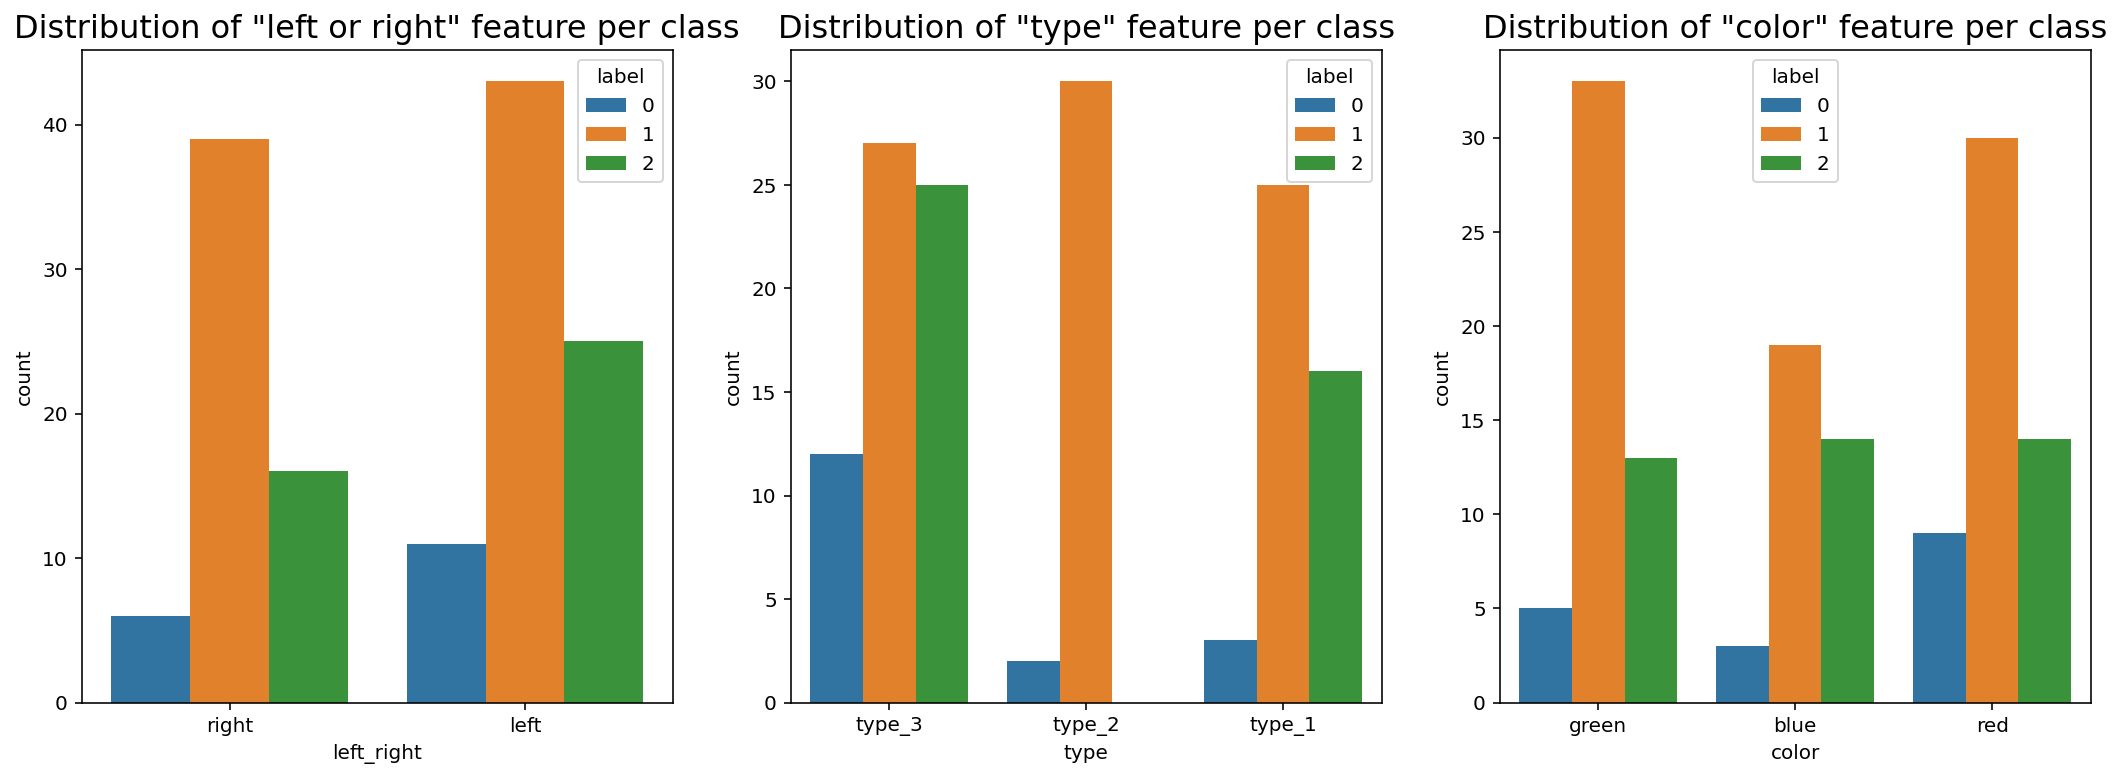

<IPython.core.display.Javascript object>

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
sns.countplot(x="left_right", hue="label", data=cat_train_data, ax=ax[0])
ax[0].set_title('Distribution of "left or right" feature per class', fontsize=16)
sns.countplot(x="type", hue="label", data=cat_train_data, ax=ax[1])
ax[1].set_title('Distribution of "type" feature per class', fontsize=16)
sns.countplot(x="color", hue="label", data=cat_train_data, ax=ax[2])
ax[2].set_title('Distribution of "color" feature per class', fontsize=16)

Text(0.5, 1.0, 'Distribution of first five numerical features')

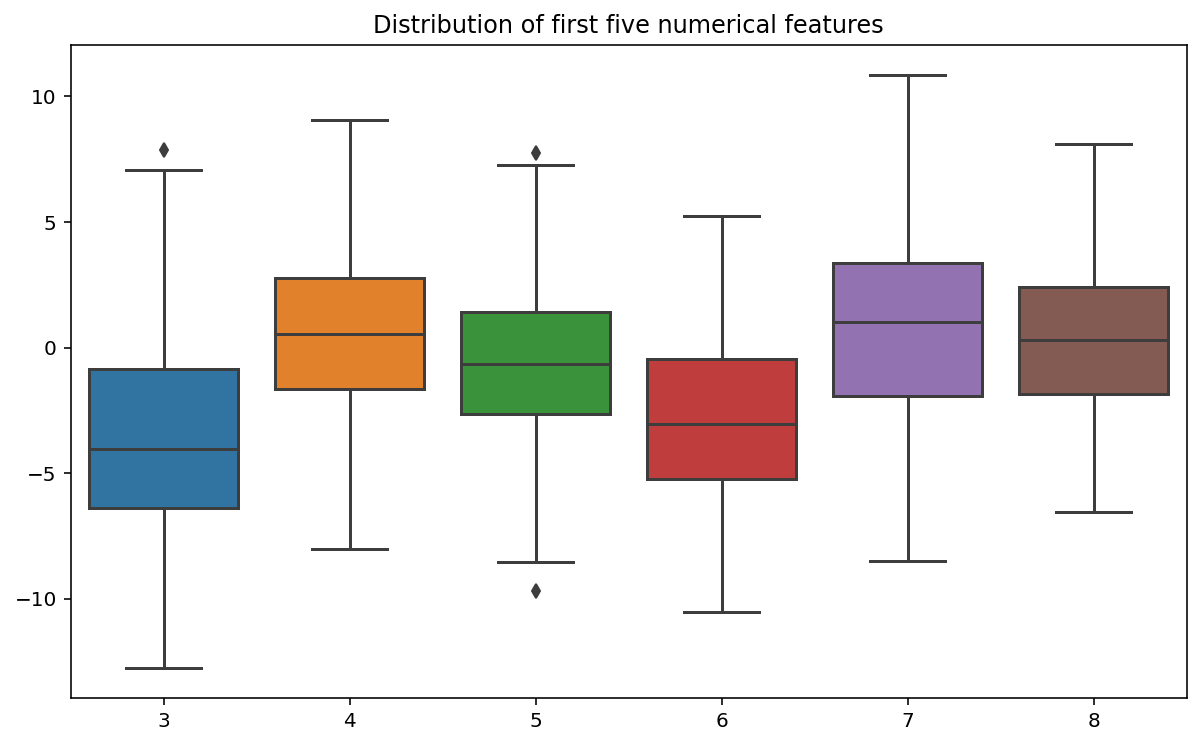

<IPython.core.display.Javascript object>

In [15]:
# ====================================
# Numerical Feature Exploration
# ====================================
plt.figure(figsize=(10, 6))
sns.boxplot(data=num_features[num_features.columns[:6]])
plt.title("Distribution of first five numerical features")

Text(0.5, 1.0, 'Distribution of label')

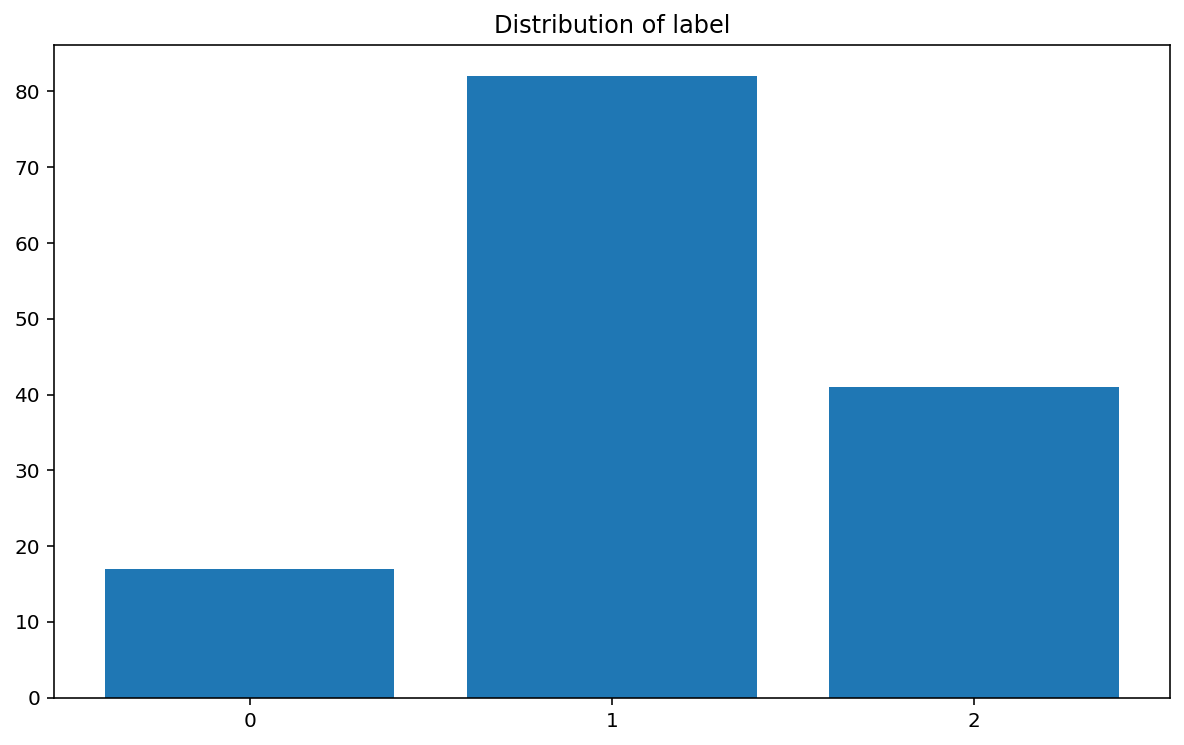

<IPython.core.display.Javascript object>

In [16]:
# ==================
# Label Exploration
# ==================
plt.figure(figsize=(10, 6))
label_keys = [str(i) for i in label_dist.index]
plt.bar(label_keys, label_dist.values)
plt.title("Distribution of label")

### 2. Preprocessing 

In [17]:
# Get categorical and numerical columns
cat_cols = [i for i in cat_features.columns]
num_cols = [i for i in num_features.columns]

# Preprocessing for numerical data
numerical_transformer  = Pipeline(steps=[('scaler', MinMaxScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])


<IPython.core.display.Javascript object>

In [18]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                  16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
                                  27, 28, 29, 30, 31, 32, ...]),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [0, 1, 2])])

<IPython.core.display.Javascript object>

### 3. Model and Hyperparameter Tuning

#### 3a. Pretuned XGB Classfier

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=0, stratify=y)

<IPython.core.display.Javascript object>

In [20]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap="bone"):
    """
    Plots Confusion Matrix
    
    Params
    ======
    cm: color map 
    classes: array of labels 
    
    Returns
    ======
    None
    """
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(
            norm_cm,
            annot=cm,
            fmt="g",
            xticklabels=classes,
            yticklabels=classes,
            cmap=cmap,
        )

<IPython.core.display.Javascript object>

In [21]:
def get_prediction_and_metrics(x_train, y_train, x_val, y_val, model):
    """
    Get predictions and prints classification report 
    
    Params
    =======
    x_train: train set
    y_train: train label 
    x_val: validation set 
    y_val: validation label
    
    Returns
    =======
    y_pred: predictions on validation set
    """
    model_xgb = model.fit(preprocessor.fit_transform(x_train), y_train)
    y_pred = model_xgb.predict(preprocessor.fit_transform(x_val))
    frog_cm = confusion_matrix(y_val, y_pred)
    print(classification_report(y_val, y_pred,))
    plot_confusion_matrix(frog_cm, classes=["class " + str(i) for i in label_keys])
    return y_pred

<IPython.core.display.Javascript object>

In [22]:
pretuned_xgb = xgb.XGBClassifier()

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.91      0.95      0.93        21
           2       1.00      0.90      0.95        10

    accuracy                           0.91        35
   macro avg       0.89      0.87      0.88        35
weighted avg       0.92      0.91      0.91        35



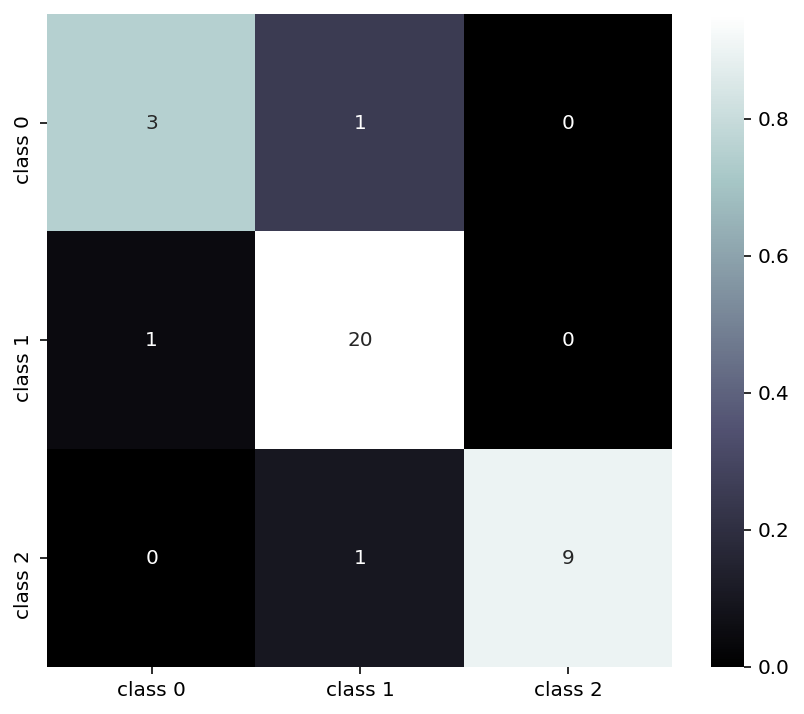

<IPython.core.display.Javascript object>

In [23]:
pretuned_y_pred = get_prediction_and_metrics(
    x_train, y_train, x_val, y_val, model=pretuned_xgb
)

#### 3b. Tuned XGB classifier

In [24]:
param_grid = {
    "learning_rate": [0.01, 0.1, 0.5, 1],
    "max_depth": [3, 5, 6, 7],
    "subsample": [0.5, 0.8, 1],
    "n_estimators": [10, 50, 100, 300],
}

grid_cv = GridSearchCV(
    estimator=xgb.XGBClassifier(), param_grid=param_grid, cv=5, scoring="accuracy"
)

<IPython.core.display.Javascript object>

In [25]:
grid_cv.fit(preprocessor.fit_transform(x_train), y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                   

<IPython.core.display.Javascript object>

In [26]:
grid_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}

<IPython.core.display.Javascript object>

In [27]:
tuned_xgb = grid_cv.best_estimator_

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.81      1.00      0.89        21
           2       1.00      0.80      0.89        10

    accuracy                           0.86        35
   macro avg       0.94      0.68      0.73        35
weighted avg       0.88      0.86      0.84        35



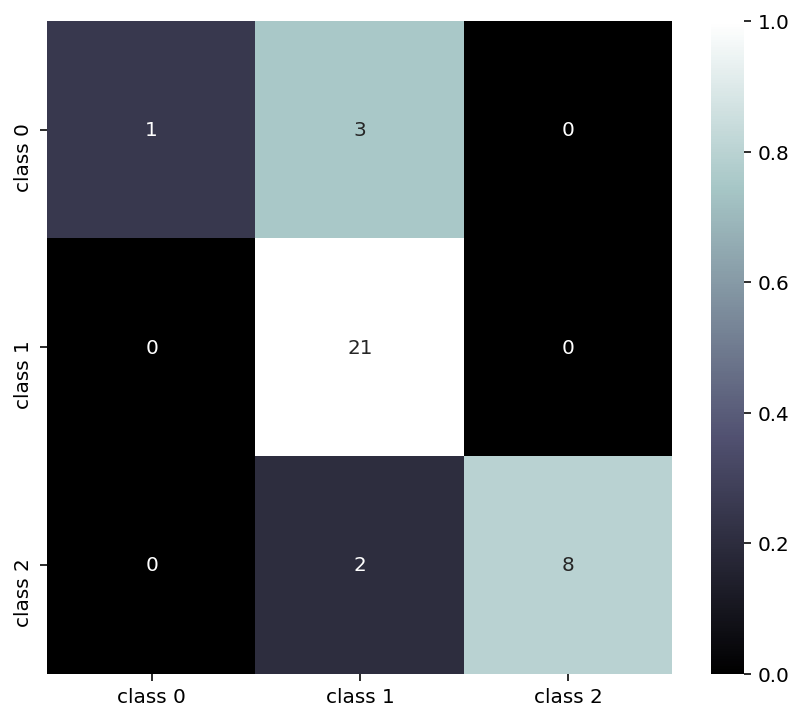

<IPython.core.display.Javascript object>

In [28]:
tuned_y_pred = get_prediction_and_metrics(
    x_train, y_train, x_val, y_val, model=tuned_xgb
)

#### 3c. Tuned XGB classifier with Data Imbalance Weighting 

In [29]:
classes_weights = class_weight.compute_sample_weight(
    class_weight="balanced", y=y_train[0]
)

<IPython.core.display.Javascript object>

In [30]:
dtrain = xgb.DMatrix(
    data=preprocessor.transform(x_train), label=y_train, weight=classes_weights
)
dval = xgb.DMatrix(data=preprocessor.transform(x_val))

<IPython.core.display.Javascript object>

In [31]:
best_params = grid_cv.best_params_.copy()

<IPython.core.display.Javascript object>

In [32]:
best_params["num_parallel_tree"] = best_params["n_estimators"]
best_params.pop("n_estimators")

50

<IPython.core.display.Javascript object>

In [33]:
params = {
    "objective": "multi:softmax",  # error evaluation for multiclass training
    "num_class": 3,
    "n_jobs": -1,
    **best_params,
}
bst = xgb.train(params, dtrain)

<IPython.core.display.Javascript object>

In [34]:
pred = bst.predict(dval)

<IPython.core.display.Javascript object>

In [35]:
print(classification_report(y_val, pred,))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.78      1.00      0.88        21
           2       1.00      0.60      0.75        10

    accuracy                           0.83        35
   macro avg       0.93      0.70      0.76        35
weighted avg       0.87      0.83      0.82        35



<IPython.core.display.Javascript object>

In [36]:
frog_cm = confusion_matrix(y_val, pred)

<IPython.core.display.Javascript object>

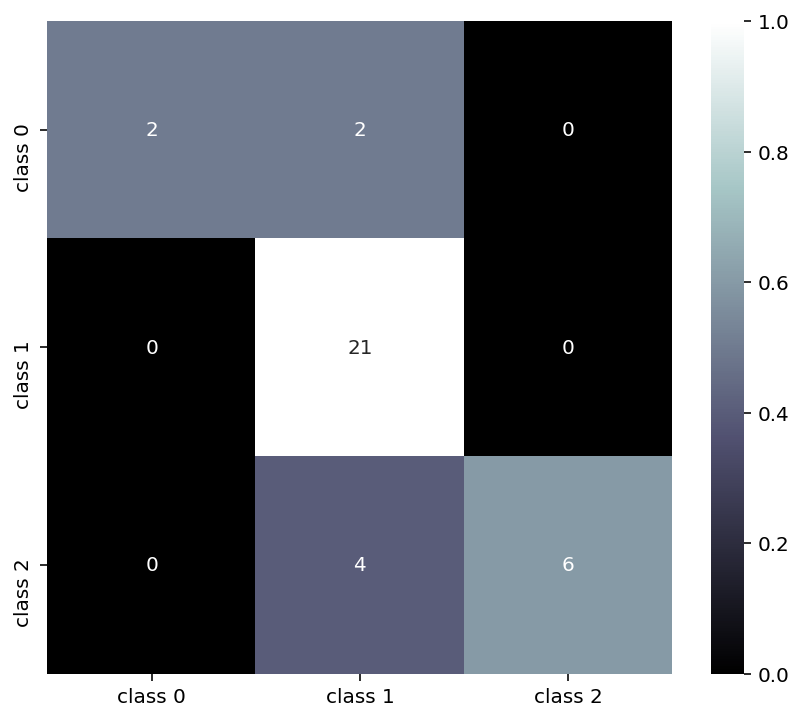

<IPython.core.display.Javascript object>

In [37]:
plot_confusion_matrix(frog_cm, classes=["class " + str(i) for i in label_keys])

### 4. Prediction with best model on entire training set

Observation: Pre tuned XGB model gave us the best result and we will fit that to the enetire training data and predict on the test data set.

In [38]:
model = xgb.XGBClassifier()
model_xgb = model.fit(preprocessor.fit_transform(x), y)
y_pred = model_xgb.predict(preprocessor.fit_transform(x_test))

<IPython.core.display.Javascript object>

In [39]:
predictions = pd.DataFrame({0: y_pred})

<IPython.core.display.Javascript object>

In [40]:
predictions.to_csv("predictions.csv")

<IPython.core.display.Javascript object>

In [41]:
predictions

,0
0,1
1,2
2,1
3,1
4,1
...,...
555,2
556,2
557,2
558,1


<IPython.core.display.Javascript object>